In [1]:
'''
Author: ChenHJ
Date: 2022-10-09 16:47:36
LastEditors: ChenHJ
LastEditTime: 2022-10-09 17:00:33
FilePath: /chenhj/0302code/recalculate_westerly_jet.ipynb
Aim:
This file is to calculate the location of westerly jet, especially its exit region. 
Mission: 
'''

'\nAuthor: ChenHJ\nDate: 2022-10-09 16:47:36\nLastEditors: ChenHJ\nLastEditTime: 2022-10-09 17:00:33\nFilePath: /chenhj/0302code/recalculate_westerly_jet.ipynb\nAim:\nThis file is to calculate the location of westerly jet, especially its exit region. \nMission: \n'

In [2]:
# read the packages
from mailbox import _PartialFile
import numpy as np
import xarray as xr
import os
import re
from cdo import Cdo

import shutil
import sys

sys.path.append("/home/ys17-23/chenhj/self_def/")
import plot as sepl
import cal as ca
import pandas as pd
from importlib import reload

import metpy.calc as mpcalc
import metpy.constants as constants
import geocat.comp
from windspharm.xarray import VectorWind
import skill_metrics as sm
from brokenaxes import brokenaxes

reload(sepl)

# sd.path.append("/home/ys17-23/chenhj/1201code/self_def.py")

cdo = Cdo()

# for plot
import proplot as pplt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter
from cartopy.mpl.ticker import LatitudeFormatter
from cartopy.util import add_cyclic_point
from matplotlib.ticker import MultipleLocator
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import t
from scipy import signal
from eofs.multivariate.standard import MultivariateEof
from eofs.standard import Eof

In [3]:
#   read data from observation data
fpreGPCP = xr.open_dataset(
    "/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/obs/GPCP_r144x72_197901-201412.nc"
)
preGPCP = fpreGPCP["precip"]
preGPCP_JJA = ca.p_time(preGPCP, 6, 8, True)

# preAIR = xr.open_dataarray("/home/ys17-23/Extension/All_India_Rainfall_index/AIR_mmperday.nc")
# preAIR_JJA = ca.p_time(preAIR, 6, 8, True)
# preAIR_JJA = preAIR_JJA.sel(time=(preAIR_JJA.time.dt.year>=1979) & (preAIR_JJA.time.dt.year <=2014))

fhgtERA5 = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/obs/hgt_mon_r144x72_195001-201412.nc")
hgtERA5 = fhgtERA5["z"].sel(time=fhgtERA5["time"].dt.year>=1979)

fuERA5 = xr.open_dataset(
    "/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/obs/uwind_mon_r144x72_195001-201412.nc"
)
uERA5 = fuERA5["u"].sel(time=fuERA5["time"].dt.year>=1979)

fvERA5 = xr.open_dataset(
    "/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/obs/vwind_mon_r144x72_195001-201412.nc"
)
vERA5 = fvERA5["v"].sel(time=fvERA5["time"].dt.year>=1979)

fspERA5 = xr.open_dataset(
    "/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/obs/sp_mon_r144x72_195001-201412.nc"
)
spERA5 = fspERA5["sp"].sel(time=fspERA5["time"].dt.year>=1979)

fqERA5 = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/obs/q_mon_r144x72_195001-201412.nc")
qERA5 = fqERA5["q"].sel(time=fqERA5["time"].dt.year>=1979)

fwERA5 = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/obs/omega_mon_r144x72_195001-201412.nc")
wERA5 = fwERA5["w"].sel(time=fwERA5["time"].dt.year>=1979)

fsstHad = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/obs/HadISST_r144x72_1870-2020.nc")
sstHad = fsstHad["sst"].sel(time=(fsstHad["time"].dt.year>=1979) & (fsstHad["time"].dt.year<=2014))

hgtERA5_ver_JJA = ca.p_time(hgtERA5, 6, 8, True)
hgtERA5_ver_JJA = hgtERA5_ver_JJA-hgtERA5_ver_JJA.mean(dim="lon", skipna=True)
uERA5_ver_JJA = ca.p_time(uERA5, 6, 8, True)
vERA5_ver_JJA = ca.p_time(vERA5, 6, 8, True)
qERA5_ver_JJA = ca.p_time(qERA5, 6, 9, True)
spERA5_JJA = ca.p_time(spERA5, 6, 8, True)
wERA5_JJA = ca.p_time(wERA5, 6, 8, True)
sstHad_JJA = ca.p_time(sstHad, 6, 8, True)

ftERA5 = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/obs/temp_mon_r144x72_195001-201412.nc")
tERA5 = ftERA5["t"].sel(time=ftERA5["time"].dt.year>=1979)
tERA5_ver_JJA = ca.p_time(tERA5, 6, 8, True)

In [4]:
# read the data from CMIP6 historical experiment
fprehis = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/CMIP6/historical/tmp_var/JJA/non_detrend/pr_historical_r144x72_195001-201412.nc")
prehis_JJA = fprehis["pr"].sel(time=fprehis["time"].dt.year>=1979)
prehis_JJA.attrs["units"] = "mm/day"
prehis_JJA.attrs["standard_name"] = "precipitation"

fhgthis_ver_JJA = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/CMIP6/historical/tmp_var/JJA/non_detrend/zg_historical_r144x72_195001-201412.nc")
hgthis_ver_JJA = fhgthis_ver_JJA["zg"].sel(time=fhgthis_ver_JJA["time"].dt.year>=1979)
hgthis_ver_JJA = hgthis_ver_JJA - hgthis_ver_JJA.mean(dim="lon", skipna=True)

fuhis_ver_JJA = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/CMIP6/historical/tmp_var/JJA/non_detrend/ua_historical_r144x72_195001-201412.nc")
uhis_ver_JJA = fuhis_ver_JJA["ua"].sel(time=fuhis_ver_JJA["time"].dt.year>=1979)

fvhis_ver_JJA = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/CMIP6/historical/tmp_var/JJA/non_detrend/va_historical_r144x72_195001-201412.nc")
vhis_ver_JJA = fvhis_ver_JJA["va"].sel(time=fvhis_ver_JJA["time"].dt.year>=1979)

fwhis_ver_JJA = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/CMIP6/historical/tmp_var/JJA/non_detrend/wap_historical_r144x72_195001-201412.nc") 
whis_ver_JJA = fwhis_ver_JJA["wap"].sel(time=fwhis_ver_JJA["time"].dt.year>=1979)

fssthis_JJA = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/CMIP6/historical/tmp_var/JJA/non_detrend/tos_historical_r144x72_195001-201412.nc")
ssthis_JJA = fssthis_JJA["tos"].sel(time=fssthis_JJA["time"].dt.year>=1979)

fthis_ver_JJA = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/CMIP6/historical/tmp_var/JJA/non_detrend/ta_historical_r144x72_195001-201412.nc")
this_ver_JJA = fthis_ver_JJA["ta"].sel(time=fthis_ver_JJA["time"].dt.year>=1979)

In [5]:
# read the data from CMIP6 ssp585 experiment and read the last period of ssp585
fpressp585_p3 = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/CMIP6/ssp585/tmp_var/JJA/non_detrend/pr_ssp585_r144x72_201501-209912.nc")
pressp585_p3_JJA = fpressp585_p3["pr"].sel(time=fpressp585_p3.time.dt.year>=2064)
pressp585_p3_JJA.attrs["units"] = "mm/day"
pressp585_p3_JJA.attrs["standard_name"] = "precipitation"

fhgtssp585_p3_ver_JJA = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/CMIP6/ssp585/tmp_var/JJA/non_detrend/zg_ssp585_r144x72_201501-209912.nc")
hgtssp585_p3_ver_JJA = fhgtssp585_p3_ver_JJA["zg"].sel(time=fhgtssp585_p3_ver_JJA.time.dt.year>=2064)
hgtssp585_p3_ver_JJA = hgtssp585_p3_ver_JJA - hgtssp585_p3_ver_JJA.mean(dim="lon", skipna=True)


fussp585_p3_ver_JJA = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/CMIP6/ssp585/tmp_var/JJA/non_detrend/ua_ssp585_r144x72_201501-209912.nc")
ussp585_p3_ver_JJA = fussp585_p3_ver_JJA["ua"].sel(time=fussp585_p3_ver_JJA.time.dt.year>=2064)

fvssp585_p3_ver_JJA = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/CMIP6/ssp585/tmp_var/JJA/non_detrend/va_ssp585_r144x72_201501-209912.nc")
vssp585_p3_ver_JJA = fvssp585_p3_ver_JJA["va"].sel(time=fvssp585_p3_ver_JJA.time.dt.year>=2064)

fwssp585_p3_ver_JJA = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/CMIP6/ssp585/tmp_var/JJA/non_detrend/wap_ssp585_r144x72_201501-209912.nc")
wssp585_p3_ver_JJA = fwssp585_p3_ver_JJA["wap"].sel(time=fwssp585_p3_ver_JJA.time.dt.year>=2064)

fsstssp585_p3_JJA = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/CMIP6/ssp585/tmp_var/JJA/non_detrend/tos_ssp585_r144x72_201501-209912.nc")
sstssp585_p3_JJA = fsstssp585_p3_JJA["tos"].sel(time=fsstssp585_p3_JJA.time.dt.year>=2064)

ftssp585_p3_ver_JJA = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/CMIP6/ssp585/tmp_var/JJA/non_detrend/ta_ssp585_r144x72_201501-209912.nc")
tssp585_p3_ver_JJA = ftssp585_p3_ver_JJA["ta"].sel(time=ftssp585_p3_ver_JJA.time.dt.year>=2064)

In [11]:
# calculate the westerly jet shift index in different models
ujet_shift_ssp585_p3 = (ca.cal_area_weighted_mean(ussp585_p3_ver_JJA.sel(level=200.0).loc[:, :, 40:50, 120:150]) - ca.cal_area_weighted_mean(ussp585_p3_ver_JJA.sel(level=200.0).loc[:, :, 30:40, 120:150])).mean(dim="time", skipna=True)
ujet_shift_his = (ca.cal_area_weighted_mean(uhis_ver_JJA.sel(level=200.0).loc[:, :, 40:50, 120:150]) - ca.cal_area_weighted_mean(uhis_ver_JJA.sel(level=200.0).loc[:, :, 30:40, 120:150])).mean(dim="time", skipna=True)
ujet_shift_diff = ujet_shift_ssp585_p3 - ujet_shift_his

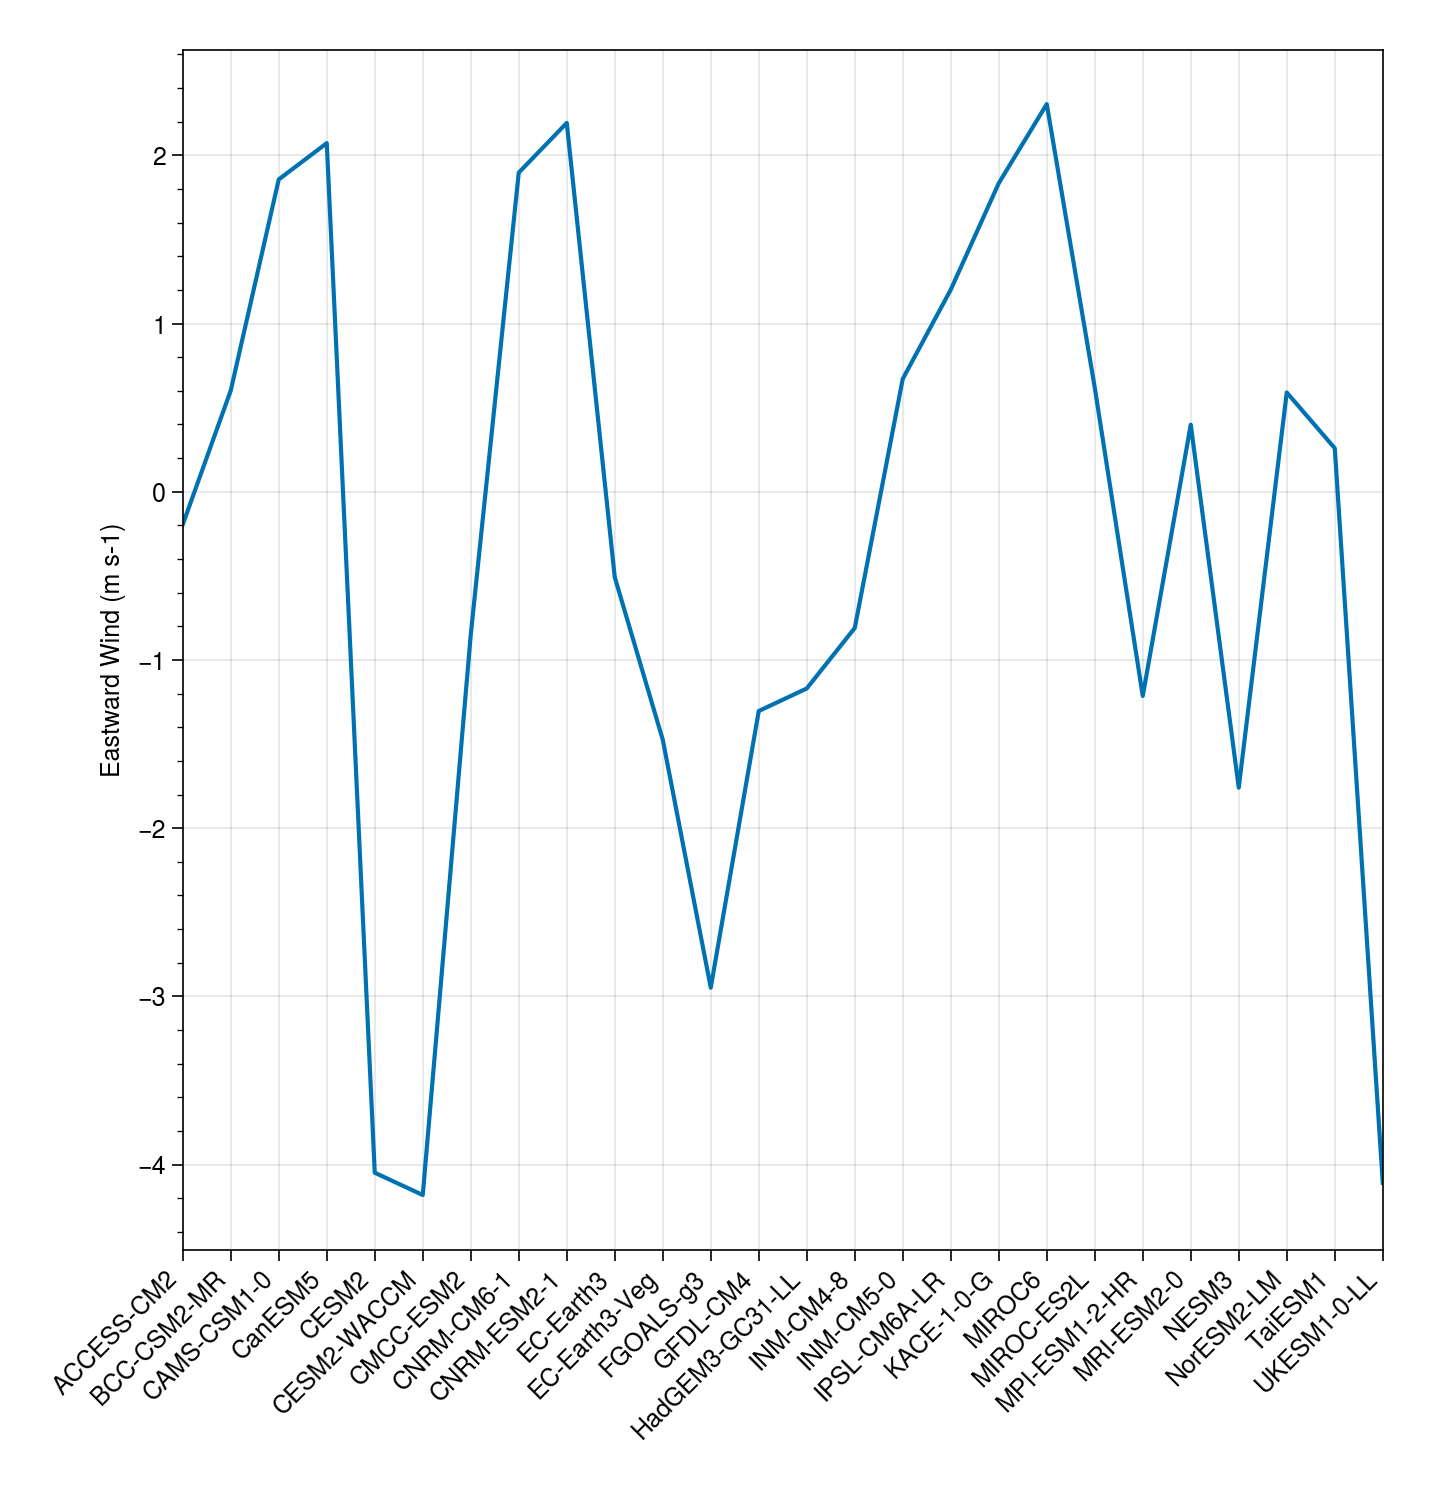

In [14]:
pplt.rc["figure.facecolor"] = "white"
pplt.rc["font.large"] = 15

fig = pplt.figure(span=False, share=False, refwidth=6.0, wspace=6.0, hspace=5.5, outerpad=2.0)
axs = fig.subplots(ncols=1, nrows=1)

axs.line(np.array(ujet_shift_diff.models), ujet_shift_diff)
axs.format(xrotation=45)

In [15]:
# calculate the shift index in MME
ujet_shift_diff.mean(dim="models")

<xarray.DataArray 'ua' ()>
array(-0.31026949)
Coordinates:
    level    float64 200.0
Attributes:
    standard_name:  eastward_wind
    long_name:      Eastward Wind
    units:          m s-1
    comment:        Zonal wind (positive in a eastward direction).
    cell_methods:   time: mean
    cell_measures:  area: areacella
    history:        2019-11-08T05:45:51Z altered by CMOR: replaced missing va...

In [18]:
# calculate the shift index in gMME
gmodels = ["CAMS-CSM1-0", "CESM2-WACCM", "CMCC-ESM2", "INM-CM4-8", "MRI-ESM2-0", "UKESM1-0-LL"]
ujet_shift_diff.sel(models=gmodels).mean(dim="models")
ujet_shift_ssp585_p3_gMME = ujet_shift_ssp585_p3.sel(models=gmodels).mean(dim="models")
ujet_shift_his_gMME = ujet_shift_his.sel(models=gmodels).mean(dim="models")

In [19]:
# calculate the westerly jet shift index in different models
ujet_shift_ssp585_p3 = (ca.cal_area_weighted_mean(ussp585_p3_ver_JJA.sel(level=200.0).loc[:, :, 40:50, 110:130]) - ca.cal_area_weighted_mean(ussp585_p3_ver_JJA.sel(level=200.0).loc[:, :, 30:40, 110:130])).mean(dim="time", skipna=True)
ujet_shift_his = (ca.cal_area_weighted_mean(uhis_ver_JJA.sel(level=200.0).loc[:, :, 40:50, 110:130]) - ca.cal_area_weighted_mean(uhis_ver_JJA.sel(level=200.0).loc[:, :, 30:40, 110:130])).mean(dim="time", skipna=True)
ujet_shift_diff = ujet_shift_ssp585_p3 - ujet_shift_his

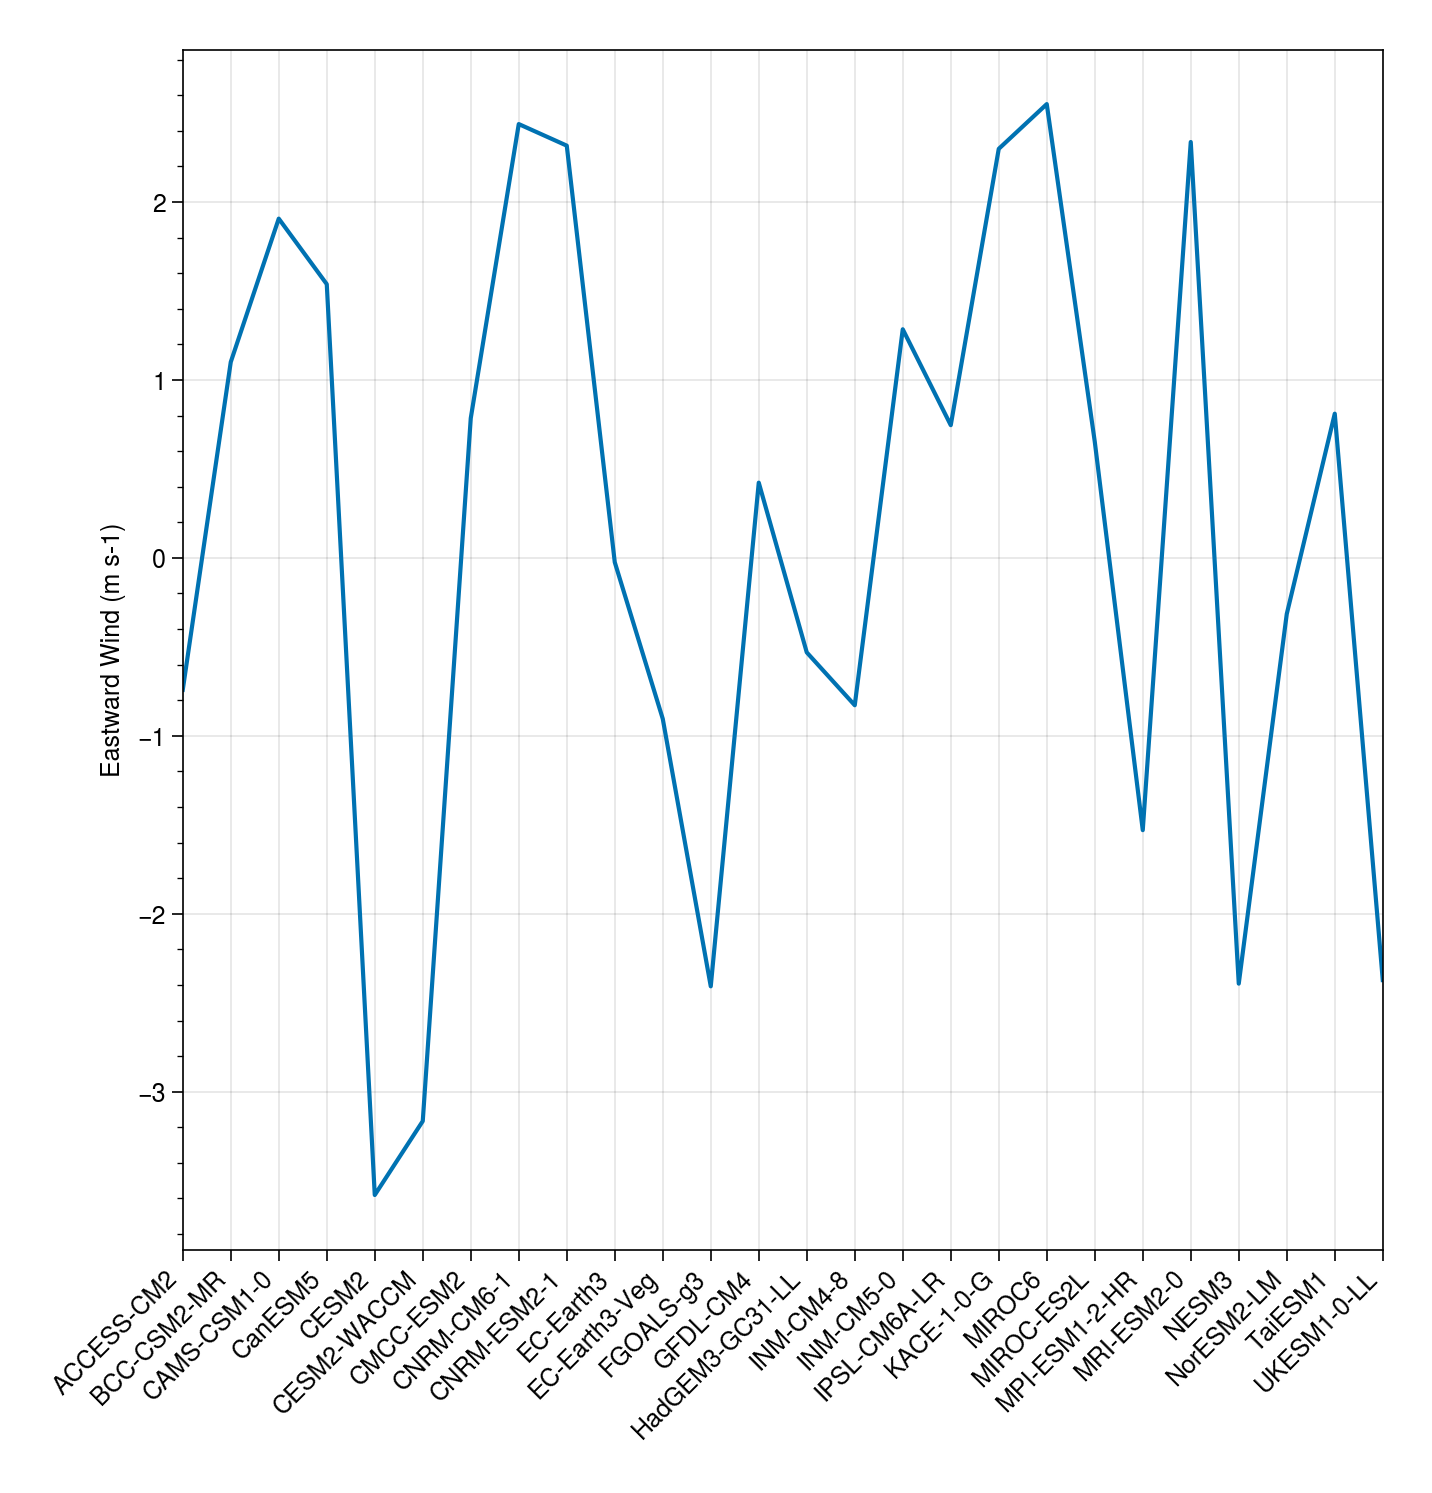

In [20]:
pplt.rc["figure.facecolor"] = "white"
pplt.rc["font.large"] = 15

fig = pplt.figure(span=False, share=False, refwidth=6.0, wspace=6.0, hspace=5.5, outerpad=2.0)
axs = fig.subplots(ncols=1, nrows=1)

axs.line(np.array(ujet_shift_diff.models), ujet_shift_diff)
axs.format(xrotation=45)

In [21]:
# calculate the shift index in MME
ujet_shift_diff.mean(dim="models")

<xarray.DataArray 'ua' ()>
array(0.09195239)
Coordinates:
    level    float64 200.0
Attributes:
    standard_name:  eastward_wind
    long_name:      Eastward Wind
    units:          m s-1
    comment:        Zonal wind (positive in a eastward direction).
    cell_methods:   time: mean
    cell_measures:  area: areacella
    history:        2019-11-08T05:45:51Z altered by CMOR: replaced missing va...

In [23]:
# calculate the shift index in gMME
gmodels = ["CAMS-CSM1-0", "CESM2-WACCM", "CMCC-ESM2", "INM-CM4-8", "MRI-ESM2-0", "UKESM1-0-LL"]
print(ujet_shift_diff.sel(models=gmodels).mean(dim="models"))
ujet_shift_ssp585_p3_gMME = ujet_shift_ssp585_p3.sel(models=gmodels).mean(dim="models")
ujet_shift_his_gMME = ujet_shift_his.sel(models=gmodels).mean(dim="models")# calculate the shift index in gMME
gmodels = ["CAMS-CSM1-0", "CESM2-WACCM", "CMCC-ESM2", "INM-CM4-8", "MRI-ESM2-0", "UKESM1-0-LL"]
ujet_shift_diff.sel(models=gmodels).mean(dim="models")
ujet_shift_ssp585_p3_gMME = ujet_shift_ssp585_p3.sel(models=gmodels).mean(dim="models")
ujet_shift_his_gMME = ujet_shift_his.sel(models=gmodels).mean(dim="models")

<xarray.DataArray 'ua' ()>
array(-0.22302264)
Coordinates:
    level    float64 200.0
Attributes:
    standard_name:  eastward_wind
    long_name:      Eastward Wind
    units:          m s-1
    comment:        Zonal wind (positive in a eastward direction).
    cell_methods:   time: mean
    cell_measures:  area: areacella
    history:        2019-11-08T05:45:51Z altered by CMOR: replaced missing va...


In [24]:
print(ujet_shift_diff.sel(models=gmodels))

<xarray.DataArray 'ua' (models: 6)>
array([ 1.9063479 , -3.16531958,  0.78480385, -0.82833242,  2.33702342,
       -2.372659  ])
Coordinates:
    level    float64 200.0
  * models   (models) object 'CAMS-CSM1-0' 'CESM2-WACCM' ... 'UKESM1-0-LL'
Attributes:
    standard_name:  eastward_wind
    long_name:      Eastward Wind
    units:          m s-1
    comment:        Zonal wind (positive in a eastward direction).
    cell_methods:   time: mean
    cell_measures:  area: areacella
    history:        2019-11-08T05:45:51Z altered by CMOR: replaced missing va...
